<a href="https://colab.research.google.com/github/VladislavsLuksha/Statistical-Methods-For-ML-Image-Classification/blob/main/Cats_and_Dogs_Image_Classification_(Uladzislau_Luksha).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##DATA IMPORT

####Data import directrly from the website

In [ ]:
# upload the data set in to my google colab
!wget https://unimibox.unimi.it/index.php/s/eNGYGSYmqynNMqF/download \
      -P /image/

--2023-01-15 01:33:47--  https://unimibox.unimi.it/index.php/s/eNGYGSYmqynNMqF/download
Resolving unimibox.unimi.it (unimibox.unimi.it)... 159.149.53.190
Connecting to unimibox.unimi.it (unimibox.unimi.it)|159.149.53.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/image/download’

download                [    <=>             ]   1.99M  1.90MB/s               ^C


In [ ]:
from zipfile import ZipFile as zipfile
import os
# then i Open the zip file containing all the images
# opening the zip file in read mode
with zipfile('/image/download', 'r') as zipped:
    # printing all the contents of the zip file
    #zip.printdir() 
    # extracting all the files
    print('Extracting all the files now...')
    zipped.extractall()
    print('The images are extracted and ready for processing')

Extracting all the files now...
The images are extracted and ready for processing


####Data import from Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/MyDrive/MachineLearning/CatsDogs.zip

####START DATA PROCESSING

In [3]:
import pathlib
data_dir = pathlib.Path("/content/CatsDogs")
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

25000


In [4]:
import numpy as np
import matplotlib.pyplot as plt 
import os #to iterate throught directories
import cv2 #to do some image operations

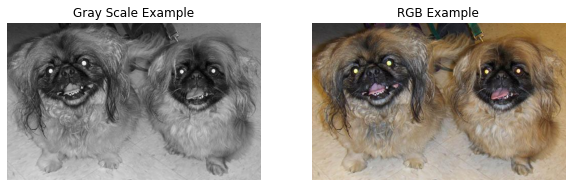

In [5]:
DIRECTORY = "/content/CatsDogs"
ANIMALS = ['Dogs','Cats']

for animal in ANIMALS:
  path = os.path.join(DIRECTORY, animal) #path to cats and dogs
  for img in os.listdir(path):
    img_array_color = cv2.imread(os.path.join(path, img),cv2.COLOR_BGR2RGB)
    img_array_gray = cv2.imread(os.path.join(path, img),cv2.IMREAD_GRAYSCALE)

    fig = plt.figure(figsize=(10, 7))

    fig.add_subplot(1, 2, 1)
    plt.imshow(img_array_gray, cmap = 'gray')
    plt.axis("off")
    plt.title("Gray Scale Example")

    fig.add_subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img_array_color, cv2.COLOR_RGB2BGR))
    plt.axis("off")
    plt.title("RGB Example")
  
    break
  break

In [6]:
print(img_array_color.shape)
print(img_array_gray.shape)

(309, 500, 3)
(309, 500)


In [7]:
import tensorflow as tf 
import random
from tensorflow import keras
random.seed(111)
np.random.seed(111)
tf.random.set_seed(111)

In [8]:
#for data prefetching
AUTOTUNE = tf.data.AUTOTUNE

In [9]:
#veryfying that we have Tensorflow 2
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.9.2


###DELETING CORRUPTED IMAGES

In [10]:
IMG_SIZE = 100

In [11]:
num_skipped = 0
total = 0
  
for animal in ANIMALS:
  folder_path = os.path.join("CatsDogs", animal)
  for img in os.listdir(folder_path):
    fpath = os.path.join(folder_path, img)
    try:
      total += 1
      fobj = open(fpath, "rb")
      is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10) #filter out badly-encoded images that do not feature the string "JFIF" in their header
    finally:
      fobj.close()
      
    if not is_jfif:
        num_skipped += 1
        # Delete corrupted image
        os.remove(fpath)

print("Total number of images: %d; Images deleted: %d" % (total, num_skipped) )


Total number of images: 25000; Images deleted: 1590


###DATA AUGMENTATION

In [12]:
#data_augmentation 
augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation((-0.20,0.20),seed=111),
    tf.keras.layers.RandomZoom((-0.20,0.20),seed=111), 
])

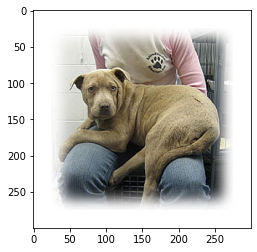

In [13]:
chosen_image = random.choice(os.listdir('/content/CatsDogs/Dogs'))
image_path = '/content/CatsDogs/Dogs/' + chosen_image
#assert os.path.isfile(image_path)
#obtain image
image = np.expand_dims(plt.imread(image_path),0)
plt.imshow(image[0])

In [14]:
aug_images = [augmentation(image)[0].numpy().astype("uint8") for i in range(10)]

In [15]:
def plotImages(images_arr):
  fig,axes = plt.subplots(2, 5,figsize = (20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

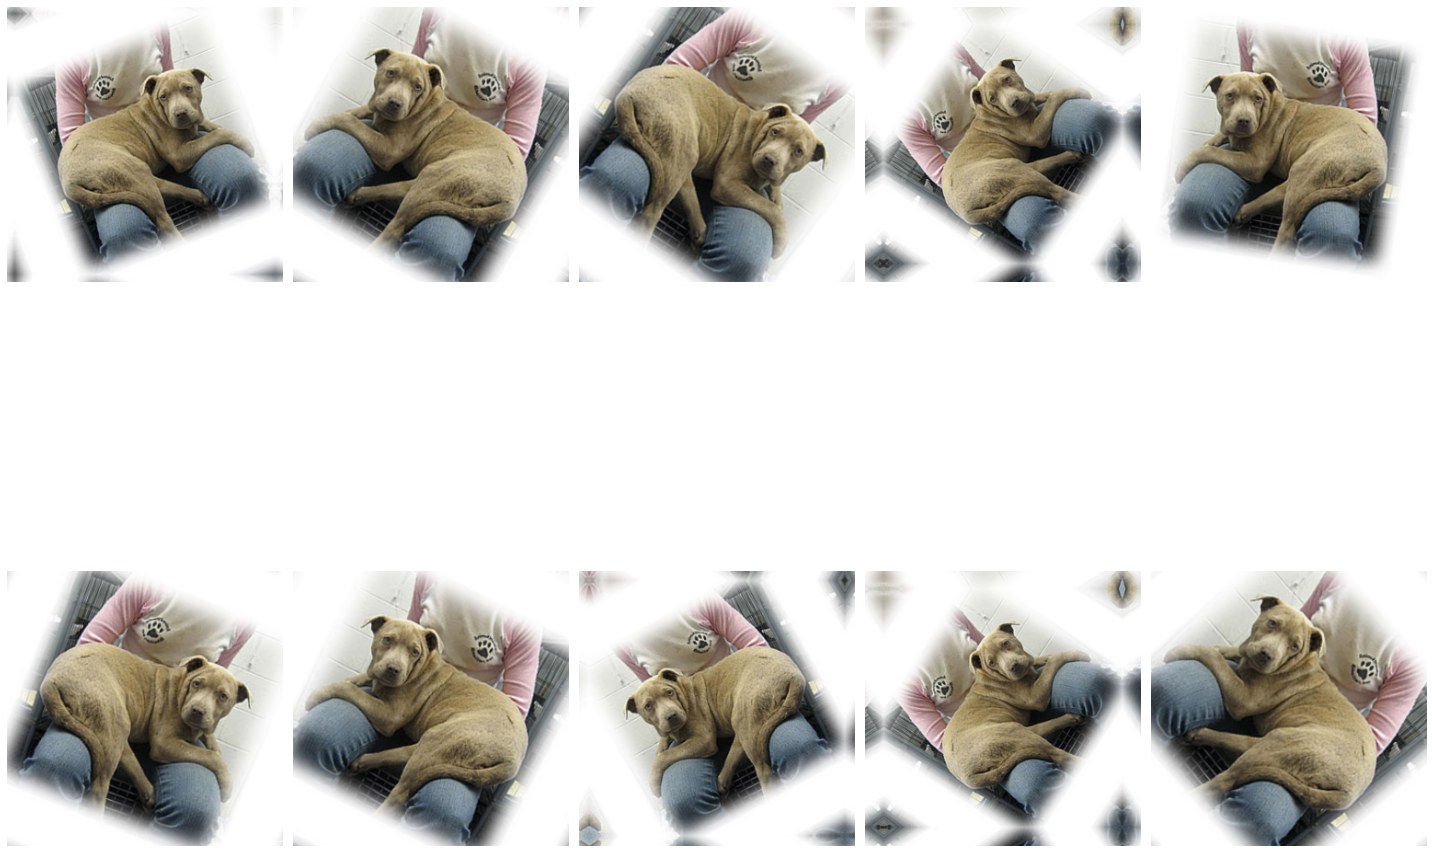

In [16]:
plotImages(aug_images)

##**GRAY PICTURES PREPROCESSING**

In [51]:
seed = 111
batch = 32

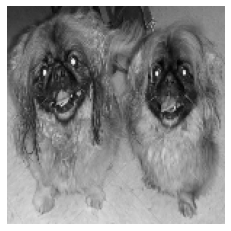

In [52]:
new_array =cv2.resize(img_array_gray, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap = 'gray')
plt.axis("off")
plt.show()

In [53]:
gray_df = []

def create_gray_df():
  for animal in ANIMALS:
    path = os.path.join(DIRECTORY, animal) #path to cats and dogs
    class_num = ANIMALS.index(animal)
    for img in os.listdir(path):
       try:
         img_array = cv2.imread(os.path.join(path, img),cv2.IMREAD_GRAYSCALE)
         new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
         gray_df.append([new_array, class_num])
       #sorting out corrupted images
       except Exception as e:
          pass

create_gray_df()
   

In [54]:
random.shuffle(gray_df)

In [55]:
print(len(gray_df))

23410


In [56]:
train_gray, validate_gray, test_gray = np.split(gray_df, [int(len(gray_df)*0.7), int(len(gray_df)*0.9)])

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [57]:
print(len(train_gray), len(train_gray)/len(gray_df))
print(len(validate_gray), len(validate_gray)/len(gray_df))
print(len(test_gray),  len(test_gray)/len(gray_df))

16387 0.7
4682 0.2
2341 0.1


In [58]:
X_train=[]
y_train=[]
for features, label in train_gray:
  X_train.append(features) 
  y_train.append(label)
# x has to be a numpy array
X_train=np.array(X_train).reshape(-1, IMG_SIZE, IMG_SIZE, 1) #-1 shows how many features we have #if colour then 3 in the end
y_train=np.array(y_train)
X_train=X_train/255.0

print((y_train == 1).sum())
print((y_train == 0).sum())

8166
8221


In [59]:
X_validate=[]
y_validate=[]
for features, label in validate_gray:
  X_validate.append(features) 
  y_validate.append(label)
# x has to be a numpy array
X_validate=np.array(X_validate).reshape(-1, IMG_SIZE, IMG_SIZE, 1) #-1 shows how many features we have #if colour then 3 in the end
y_validate=np.array(y_validate)
X_validate=X_validate/255.0

print((y_validate == 1).sum())
print((y_validate == 0).sum())

2352
2330


In [60]:
X_test=[]
y_test=[]
for features, label in test_gray:
  X_test.append(features) 
  y_test.append(label)
# x has to be a numpy array
X_test=np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 1) #-1 shows how many features we have #if colour then 3 in the end
y_test=np.array(y_test)
X_test=X_test/255.0

print((y_test == 1).sum())
print((y_test == 0).sum())

1223
1118


##**GRAY MODELS**

###MODEL 1 - CNN - GRAY

In [ ]:
IMG_SIZE = 100
seed = 111
batch = 32

In [ ]:
model_cnn= tf.keras.Sequential([
    
    augmentation,

  
    tf.keras.layers.Conv2D(64, (3,3), input_shape=X_train.shape[1:], activation = 'relu' ), #starting with convolutional layer
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(64, activation='relu'), #we need an activation function, without it it would be kinda linear activation function
    tf.keras.layers.Dense(1, activation = "sigmoid"), #adding outpul layer

], name = 'cnn_gray')

model_cnn.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['binary_accuracy'])


In [ ]:
# Callback is needed to stop the training when there is no
# improvement in the validation loss for three consecutive epochs.
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode="min")

epochs = 20
history_cnn=model_cnn.fit(
  X_train,y_train,
  validation_data = (X_validate, y_validate),
  epochs=epochs,
    verbose=1,
    callbacks=[callback]
)

Epoch 1/20
513/513 [==============================] - 11s 20ms/step - loss: 0.6782 - binary_accuracy: 0.5759 - val_loss: 0.6467 - val_binary_accuracy: 0.6354
Epoch 2/20
513/513 [==============================] - 10s 19ms/step - loss: 0.6436 - binary_accuracy: 0.6343 - val_loss: 0.6484 - val_binary_accuracy: 0.6202
Epoch 3/20
513/513 [==============================] - 10s 19ms/step - loss: 0.6213 - binary_accuracy: 0.6558 - val_loss: 0.6423 - val_binary_accuracy: 0.6388
Epoch 4/20
513/513 [==============================] - 10s 19ms/step - loss: 0.6081 - binary_accuracy: 0.6706 - val_loss: 0.5825 - val_binary_accuracy: 0.6963
Epoch 5/20
513/513 [==============================] - 10s 19ms/step - loss: 0.5911 - binary_accuracy: 0.6848 - val_loss: 0.5597 - val_binary_accuracy: 0.7157
Epoch 6/20
513/513 [==============================] - 10s 19ms/step - loss: 0.5778 - binary_accuracy: 0.6942 - val_loss: 0.5700 - val_binary_accuracy: 0.6971
Epoch 7/20
513/513 [==============================] 

In [ ]:
model_cnn.summary()

Model: "cnn_gray"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, None)  0         
                                                                 
 conv2d_12 (Conv2D)          (None, 98, 98, 64)        640       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 47, 47, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 33856)             0  

In [ ]:
model_cnn.evaluate(X_train,y_train)


513/513 [==============================] - 2s 3ms/step - loss: 0.4297 - binary_accuracy: 0.8061


[0.4297054708003998, 0.8061268329620361]

In [ ]:
model_cnn.evaluate(X_validate, y_validate)

147/147 [==============================] - 0s 3ms/step - loss: 0.4900 - binary_accuracy: 0.7719


[0.4899696409702301, 0.7718923687934875]

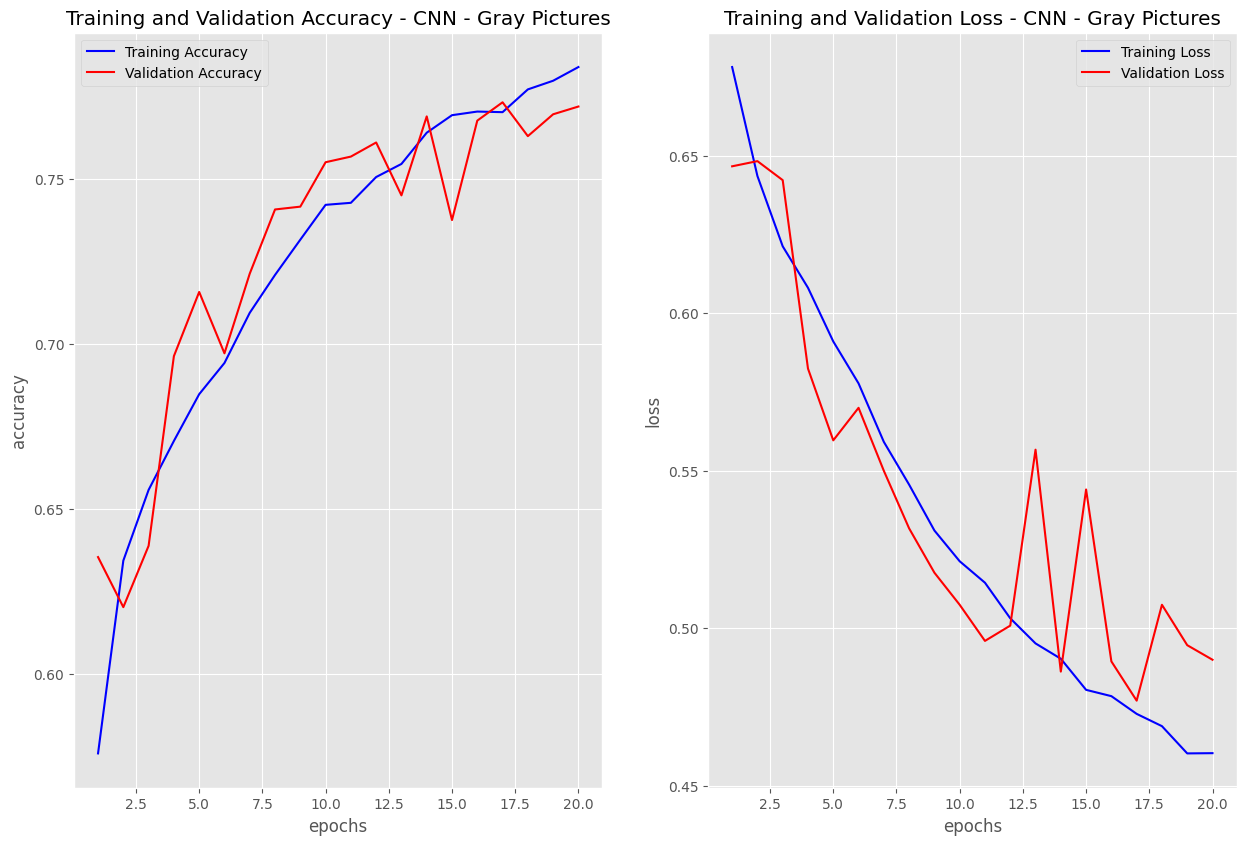

In [ ]:
#Plotting Training and Validation Accuracy |+| Training and Validation Loss
acc = history_cnn.history['binary_accuracy']
val_acc = history_cnn.history['val_binary_accuracy']

loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs_range = range(1, len(acc) + 1)
with plt.style.context('ggplot'):
  plt.figure(figsize=(15, 10), dpi= 100)

  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, 'b', label='Training Accuracy')
  plt.plot(epochs_range, val_acc, 'r', label='Validation Accuracy')
  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.title('Training and Validation Accuracy - CNN - Gray Pictures')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, 'b', label='Training Loss')
  plt.plot(epochs_range, val_loss, 'r', label='Validation Loss')
  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.title('Training and Validation Loss - CNN - Gray Pictures')



###MODEL 2 - VGG-4 - GRAY

In [61]:
IMG_SIZE = 150
seed = 111
batch = 64

In [62]:
model_vgg4= tf.keras.Sequential([
    
    augmentation,

    tf.keras.layers.Conv2D(32, (3,3), input_shape=X_train.shape[1:],strides = 1, activation = 'relu' ),

    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

    tf.keras.layers.Conv2D(64, (3,3), strides = 1, activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

    tf.keras.layers.Conv2D(128, (3,3), strides = 1, activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

    tf.keras.layers.Conv2D(256, (3,3), strides = 1, activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.1, seed=555),
    
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.1, seed=555),
    
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.1, seed=555),
    
    tf.keras.layers.Dense(1, activation='sigmoid'),  
       
        ], name = 'vgg4_gray')

model_vgg4.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['binary_accuracy'])


In [63]:
# Callback is needed to stop the training when there is no
# improvement in the validation loss for three consecutive epochs.
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode="min")

epochs = 20
history_vgg4=model_vgg4.fit(
  X_train,y_train,
  validation_data = (X_validate, y_validate),
  epochs=epochs,
    verbose=1,
    callbacks=[callback]
)

Epoch 1/20
513/513 [==============================] - 13s 23ms/step - loss: 0.6882 - binary_accuracy: 0.5405 - val_loss: 0.6899 - val_binary_accuracy: 0.5500
Epoch 2/20
513/513 [==============================] - 11s 22ms/step - loss: 0.6734 - binary_accuracy: 0.5774 - val_loss: 0.6405 - val_binary_accuracy: 0.6292
Epoch 3/20
513/513 [==============================] - 11s 21ms/step - loss: 0.6494 - binary_accuracy: 0.6257 - val_loss: 0.6130 - val_binary_accuracy: 0.6628
Epoch 4/20
513/513 [==============================] - 11s 22ms/step - loss: 0.6161 - binary_accuracy: 0.6656 - val_loss: 0.5989 - val_binary_accuracy: 0.6743
Epoch 5/20
513/513 [==============================] - 11s 21ms/step - loss: 0.5875 - binary_accuracy: 0.6913 - val_loss: 0.5429 - val_binary_accuracy: 0.7219
Epoch 6/20
513/513 [==============================] - 11s 21ms/step - loss: 0.5576 - binary_accuracy: 0.7209 - val_loss: 0.5118 - val_binary_accuracy: 0.7478
Epoch 7/20
513/513 [==============================] 

In [64]:
model_vgg4.summary()

Model: "vgg4_gray"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, None)  0         
                                                                 
 conv2d_12 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 34, 34, 128)       73

In [65]:
model_vgg4.evaluate(X_train,y_train)


513/513 [==============================] - 2s 4ms/step - loss: 0.2984 - binary_accuracy: 0.8713


[0.29835450649261475, 0.8713003993034363]

In [66]:
model_vgg4.evaluate(X_validate, y_validate)

147/147 [==============================] - 1s 4ms/step - loss: 0.3365 - binary_accuracy: 0.8488


[0.33653724193573, 0.8487825989723206]

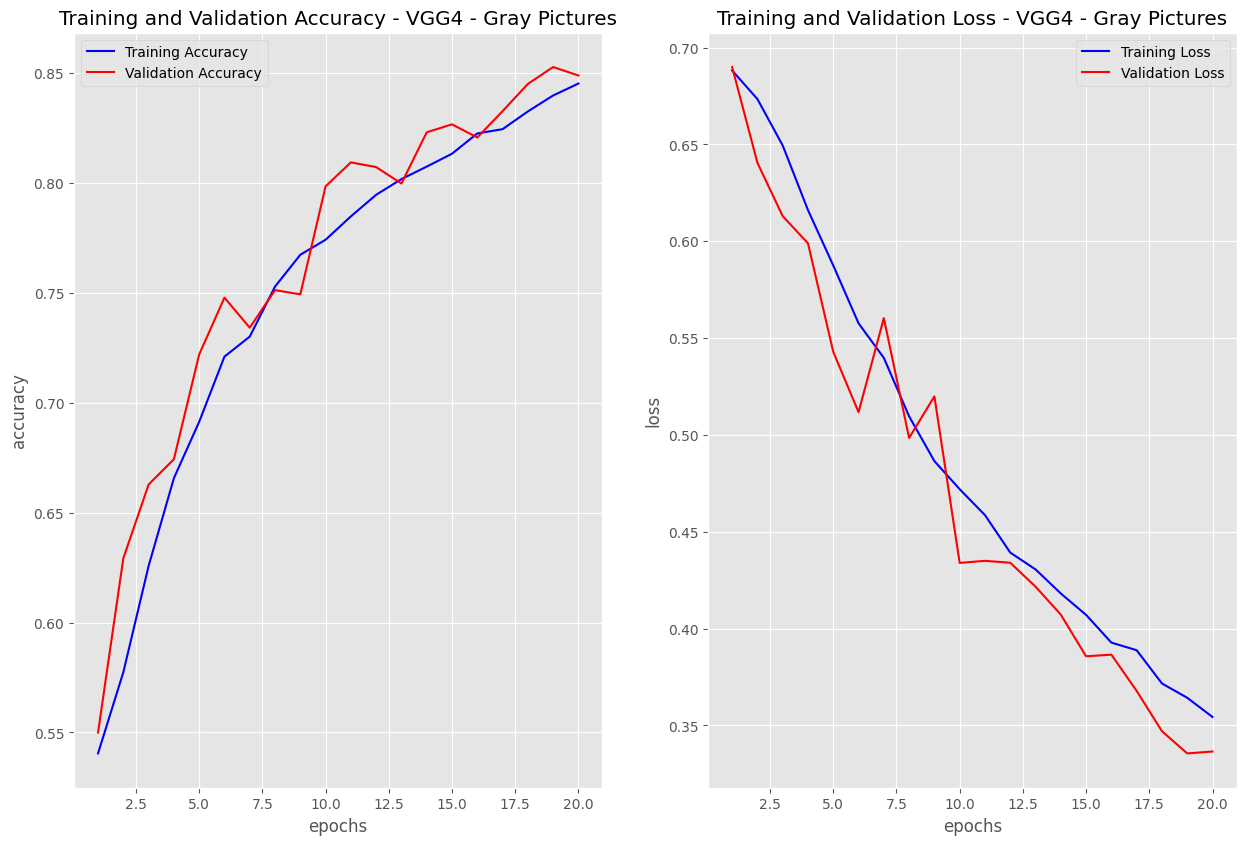

In [67]:
#Plotting Training and Validation Accuracy |+| Training and Validation Loss
acc = history_vgg4.history['binary_accuracy']
val_acc = history_vgg4.history['val_binary_accuracy']

loss = history_vgg4.history['loss']
val_loss = history_vgg4.history['val_loss']

epochs_range = range(1, len(acc) + 1)
with plt.style.context('ggplot'):
  plt.figure(figsize=(15, 10), dpi= 100)

  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, 'b', label='Training Accuracy')
  plt.plot(epochs_range, val_acc, 'r', label='Validation Accuracy')
  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.title('Training and Validation Accuracy - VGG4 - Gray Pictures')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, 'b', label='Training Loss')
  plt.plot(epochs_range, val_loss, 'r', label='Validation Loss')
  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.title('Training and Validation Loss - VGG4 - Gray Pictures')


##**COLOR PICTURES PREPROCESSING**

In [17]:
IMG_SIZE = 100
seed = 111
batch = 32

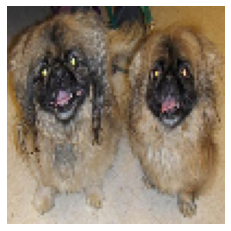

In [18]:
new_array_color=cv2.resize(img_array_color, (IMG_SIZE, IMG_SIZE), 3)
plt.imshow(cv2.cvtColor(new_array_color, cv2.COLOR_RGB2BGR))
plt.axis("off")
plt.show()

In [19]:
#splitting the dataset into validation and train
train_df_color= tf.keras.preprocessing.image_dataset_from_directory(
    DIRECTORY,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size= batch,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=seed,
    validation_split=0.3,
    subset='training',
    interpolation="bilinear",
    crop_to_aspect_ratio=False
     )


#splitting the dataset into validation and train
validation_df_color = tf.keras.preprocessing.image_dataset_from_directory(
    DIRECTORY,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size= batch,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=seed,
    validation_split=0.3,
    subset='validation',
    interpolation="bilinear",
    crop_to_aspect_ratio=False
     )

Found 23410 files belonging to 2 classes.
Using 16387 files for training.
Found 23410 files belonging to 2 classes.
Using 7023 files for validation.


In [20]:
#we need a test set which would be derived from the validation one
#https://stackoverflow.com/questions/51125266/how-do-i-split-tensorflow-datasets
test_df_color = validation_df_color.take(int(len(validation_df_color)*0.33333))
validation_df_color = validation_df_color.skip(int(len(validation_df_color)*0.33333))
print(test_df_color.cardinality().numpy()/(test_df_color.cardinality().numpy()+validation_df_color.cardinality().numpy())*100, "%")
print(validation_df_color.cardinality().numpy()/(test_df_color.cardinality().numpy()+validation_df_color.cardinality().numpy())*100, "%")

33.18181818181819 %
66.81818181818183 %


In [21]:
y = np.concatenate([y for x, y in train_df_color], axis=0)
print('training data contains' , len(y) , 'pictures, including:')
num_zeros = (y == 0).sum()
num_ones = (y == 1).sum()
print('pictures of cats:', num_zeros)
print('pictures of dogs:', num_ones)

training data contains 16387 pictures, including:
pictures of cats: 8205
pictures of dogs: 8182


In [22]:
y = np.concatenate([y for x, y in validation_df_color], axis=0)
print('validation data contains' , len(y) , 'pictures, including:')
num_zeros = (y == 0).sum()
num_ones = (y == 1).sum()
print('pictures of cats:', num_zeros)
print('pictures of dogs:', num_ones)

validation data contains 4687 pictures, including:
pictures of cats: 2316
pictures of dogs: 2371


In [23]:
y = np.concatenate([y for x, y in test_df_color], axis=0)
print('test data contains' , len(y) , 'pictures, including:')
num_zeros = (y == 0).sum()
num_ones = (y == 1).sum()
print('pictures of cats:', num_zeros)
print('pictures of dogs:', num_ones)

test data contains 2336 pictures, including:
pictures of cats: 1206
pictures of dogs: 1130


##**COLOR MODELS**

###MODEL 1 - CNN - COLOR

In [ ]:
IMG_SIZE = 100
seed = 111
batch = 32

In [ ]:
model_cnn_c = tf.keras.Sequential([
    
    augmentation,
    tf.keras.layers.Rescaling(1./255, input_shape=(IMG_SIZE,IMG_SIZE,3)),

  
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu' ), 
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(64, activation='relu'), #we need an activation function, without it it would be kinda linear activation function
    tf.keras.layers.Dense(1, activation = "sigmoid"), #adding outpul layer

], name = 'cnn_color')

model_cnn_c.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['binary_accuracy'])


In [ ]:
train_df_color = train_df_color.cache().prefetch(buffer_size=AUTOTUNE)
validation_df_color = validation_df_color.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,mode="min")

epochs = 20
history_cnn_c=model_cnn_c.fit(
  train_df_color,
  validation_data=validation_df_color,
  epochs=epochs,
    verbose=1,
    callbacks=[callback]
)

Epoch 1/20
513/513 [==============================] - 17s 31ms/step - loss: 0.6829 - binary_accuracy: 0.5691 - val_loss: 0.6442 - val_binary_accuracy: 0.6349
Epoch 2/20
513/513 [==============================] - 10s 20ms/step - loss: 0.6439 - binary_accuracy: 0.6329 - val_loss: 0.6077 - val_binary_accuracy: 0.6742
Epoch 3/20
513/513 [==============================] - 10s 20ms/step - loss: 0.6162 - binary_accuracy: 0.6672 - val_loss: 0.6057 - val_binary_accuracy: 0.6642
Epoch 4/20
513/513 [==============================] - 10s 20ms/step - loss: 0.5849 - binary_accuracy: 0.6924 - val_loss: 0.5906 - val_binary_accuracy: 0.6806
Epoch 5/20
513/513 [==============================] - 10s 20ms/step - loss: 0.5639 - binary_accuracy: 0.7079 - val_loss: 0.6048 - val_binary_accuracy: 0.6661
Epoch 6/20
513/513 [==============================] - 10s 20ms/step - loss: 0.5441 - binary_accuracy: 0.7214 - val_loss: 0.5614 - val_binary_accuracy: 0.7188
Epoch 7/20
513/513 [==============================] 

In [ ]:
model_cnn_c.summary()

Model: "cnn_color"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, None)  0         
                                                                 
 rescaling_1 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 98, 98, 64)        1792      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 47, 47, 64)        36928     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                    

In [ ]:
model_cnn_c.evaluate(train_df_color)


147/147 [==============================] - 1s 4ms/step - loss: 0.5045 - binary_accuracy: 0.7546


[0.5045243501663208, 0.754640519618988]

In [ ]:
model_cnn_c.evaluate(validation_df_color)

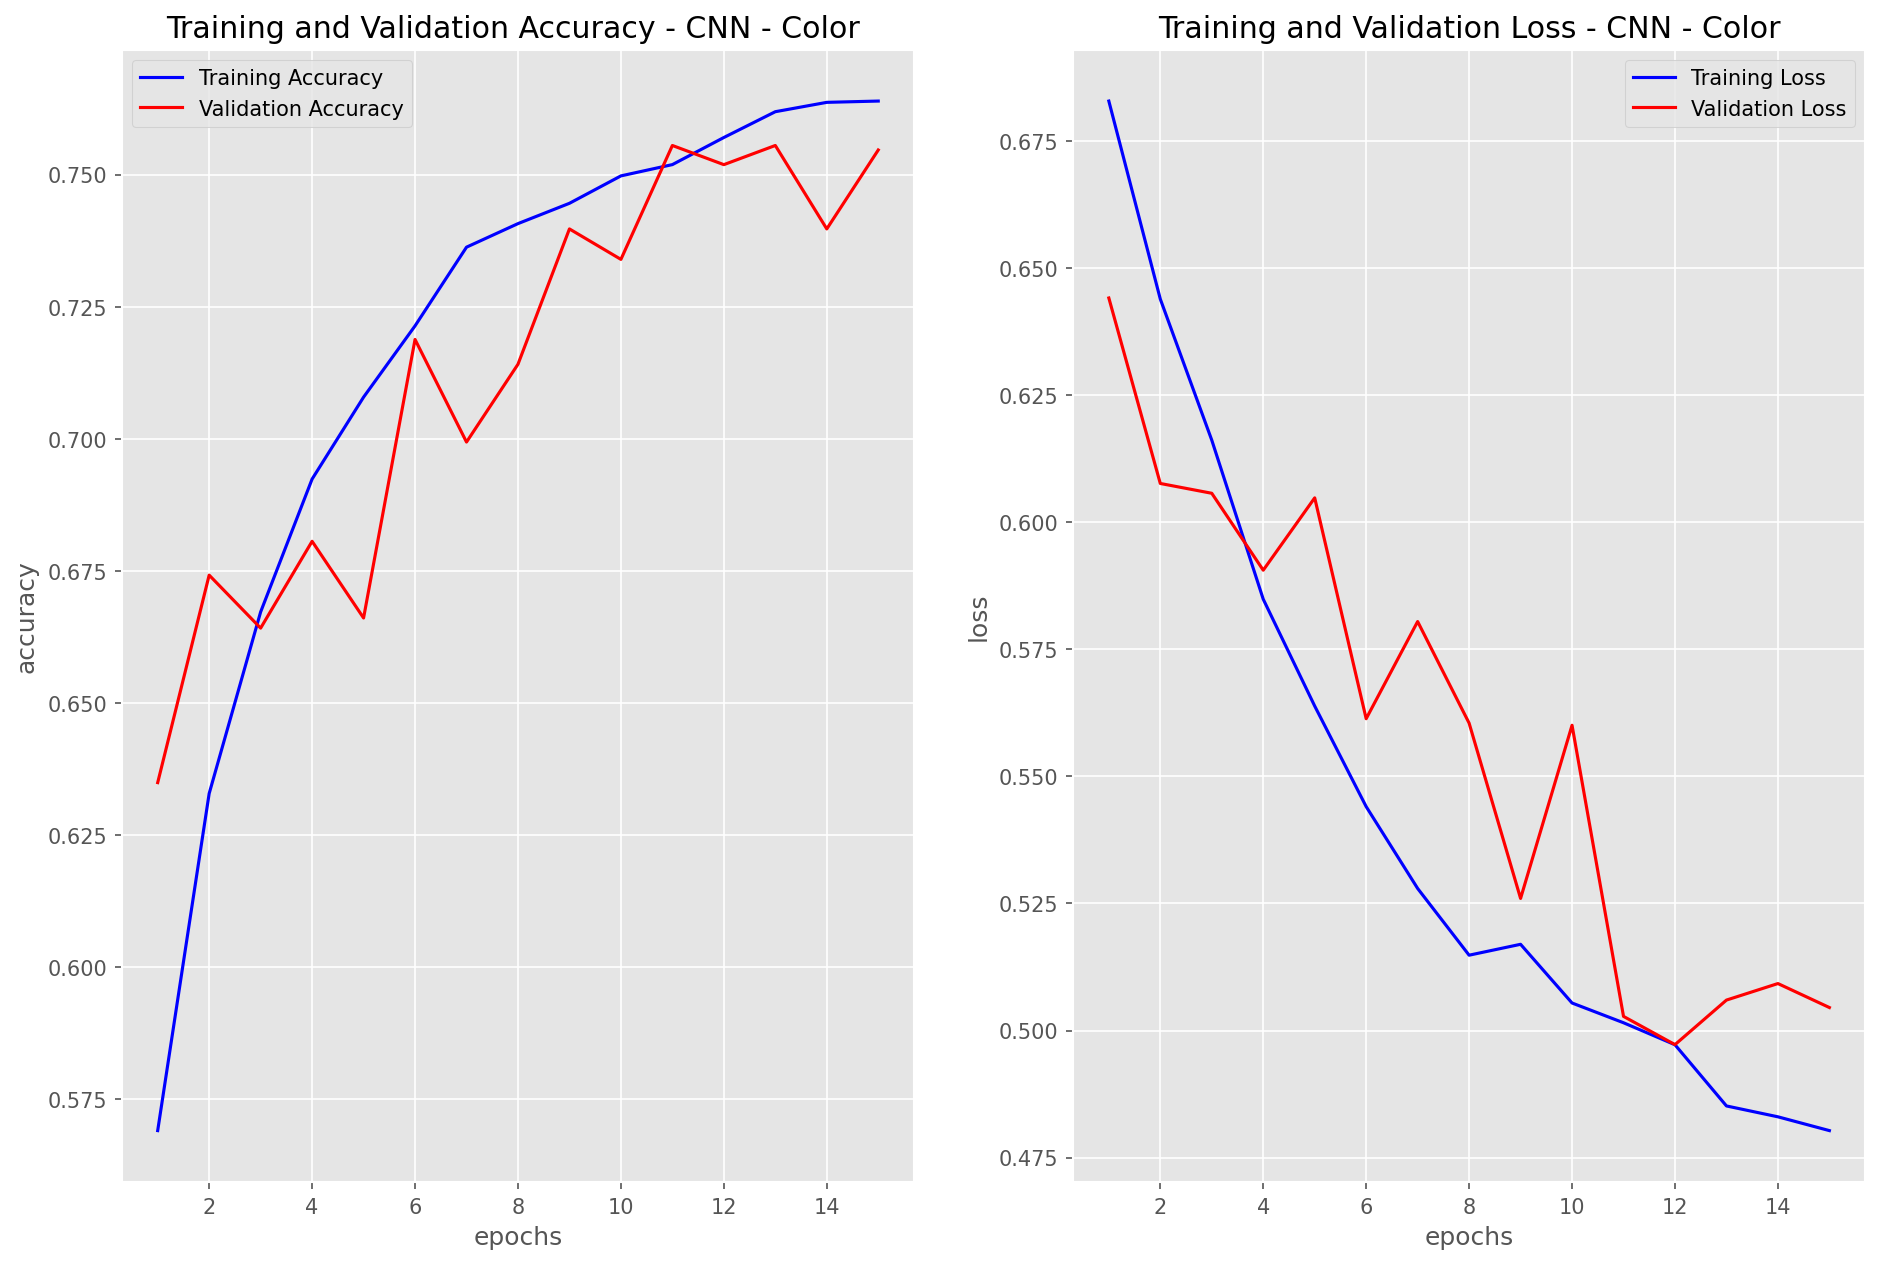

In [ ]:
#Plotting Training and Validation Accuracy |+| Training and Validation Loss
acc = history_cnn_c.history['binary_accuracy']
val_acc = history_cnn_c.history['val_binary_accuracy']
loss = history_cnn_c.history['loss']
val_loss = history_cnn_c.history['val_loss']

epochs_range = range(1, len(acc) + 1)
with plt.style.context('ggplot'):
  plt.figure(figsize=(15,10),dpi= 150)

  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, 'b', label='Training Accuracy')
  plt.plot(epochs_range, val_acc, 'r',label='Validation Accuracy')
  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.title('Training and Validation Accuracy - CNN - Color ')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, 'b', label='Training Loss')
  plt.plot(epochs_range, val_loss, 'r', label='Validation Loss')
  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.title('Training and Validation Loss - CNN - Color')

###MODEL 2 - VGG4 - COLOR

In [24]:
IMG_SIZE = 150
seed = 111
batch = 64

In [25]:
model_vgg4_c= tf.keras.Sequential([
    
    augmentation,
    tf.keras.layers.Rescaling(1./255, input_shape=(IMG_SIZE,IMG_SIZE,3)),

    tf.keras.layers.Conv2D(32, (3,3), strides = 1, activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

    tf.keras.layers.Conv2D(64, (3,3), strides = 1, activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

    tf.keras.layers.Conv2D(128, (3,3), strides = 1, activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

    tf.keras.layers.Conv2D(256, (3,3), strides = 1, activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.1, seed=111),
    
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.1, seed=111),
    
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.1, seed=111),
    
    tf.keras.layers.Dense(1, activation='sigmoid'),  
       
        ], name = 'vgg4_color')

model_vgg4_c.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['binary_accuracy'])


In [26]:
train_df_color = train_df_color.cache().prefetch(buffer_size=AUTOTUNE)
validation_df_color = validation_df_color.cache().prefetch(buffer_size=AUTOTUNE)
#test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,mode="min")

epochs = 20
history_vgg4_c=model_vgg4_c.fit(
  train_df_color,
  validation_data=validation_df_color,
  epochs=epochs,
    verbose=1,
    callbacks=[callback]
)

Epoch 1/20
513/513 [==============================] - 24s 26ms/step - loss: 0.6932 - binary_accuracy: 0.5057 - val_loss: 0.6937 - val_binary_accuracy: 0.4926
Epoch 2/20
513/513 [==============================] - 10s 19ms/step - loss: 0.6916 - binary_accuracy: 0.5170 - val_loss: 0.6871 - val_binary_accuracy: 0.5675
Epoch 3/20
513/513 [==============================] - 10s 20ms/step - loss: 0.6857 - binary_accuracy: 0.5503 - val_loss: 0.6808 - val_binary_accuracy: 0.5771
Epoch 4/20
513/513 [==============================] - 10s 20ms/step - loss: 0.6614 - binary_accuracy: 0.6116 - val_loss: 0.6900 - val_binary_accuracy: 0.5936
Epoch 5/20
513/513 [==============================] - 10s 20ms/step - loss: 0.6177 - binary_accuracy: 0.6662 - val_loss: 0.6249 - val_binary_accuracy: 0.6552
Epoch 6/20
513/513 [==============================] - 10s 20ms/step - loss: 0.5901 - binary_accuracy: 0.6985 - val_loss: 0.6212 - val_binary_accuracy: 0.6482
Epoch 7/20
513/513 [==============================] 

In [28]:
model_vgg4_c.summary()

Model: "vgg4_color"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                    

In [29]:
model_vgg4_c.evaluate(train_df_color)

513/513 [==============================] - 2s 4ms/step - loss: 0.3591 - binary_accuracy: 0.8343


[0.35914579033851624, 0.8343198895454407]

In [30]:
model_vgg4_c.evaluate(validation_df_color)

147/147 [==============================] - 1s 4ms/step - loss: 0.3783 - binary_accuracy: 0.8321


[0.3782559335231781, 0.8320887684822083]

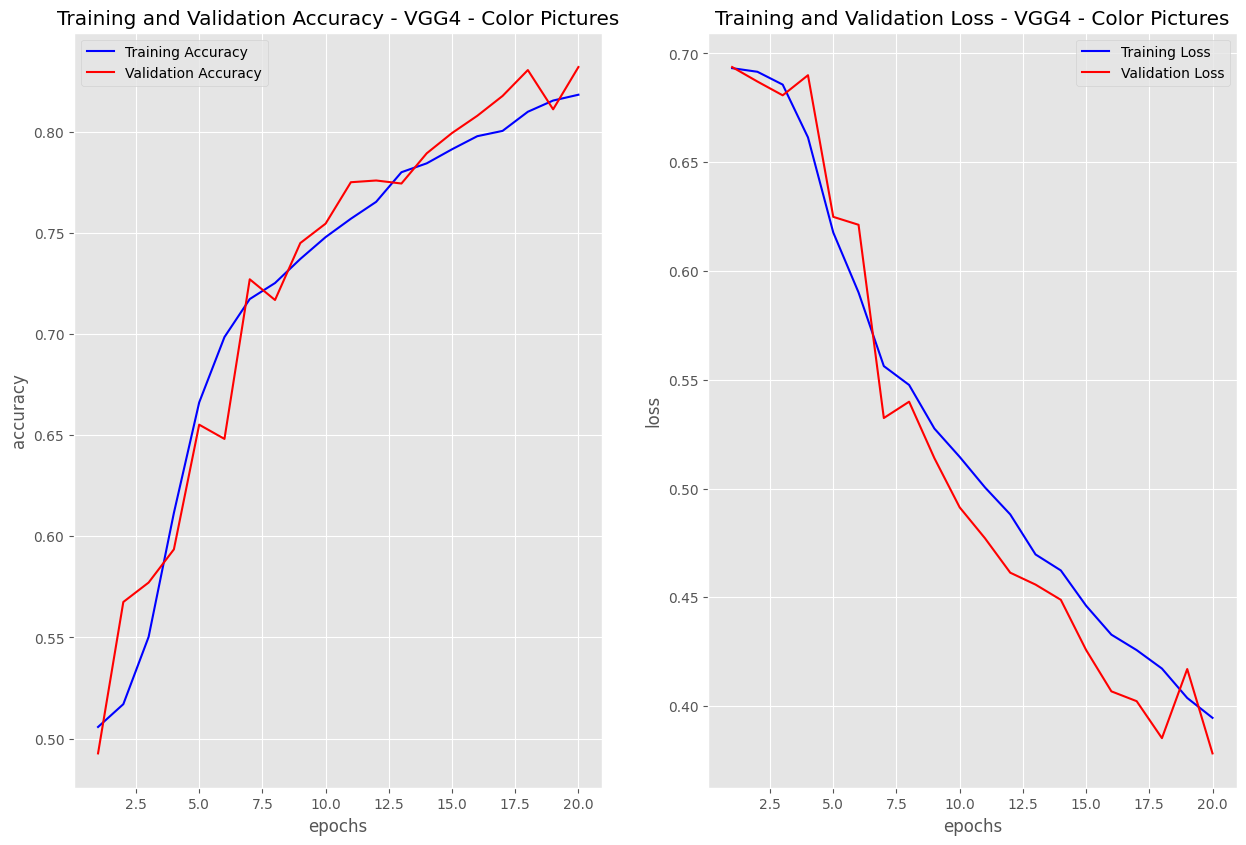

In [31]:
#Plotting Training and Validation Accuracy |+| Training and Validation Loss
acc = history_vgg4_c.history['binary_accuracy']
val_acc = history_vgg4_c.history['val_binary_accuracy']

loss = history_vgg4_c.history['loss']
val_loss = history_vgg4_c.history['val_loss']

epochs_range = range(1, len(acc) + 1)
with plt.style.context('ggplot'):
  plt.figure(figsize=(15, 10), dpi= 100)
  
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, 'b', label='Training Accuracy')
  plt.plot(epochs_range, val_acc, 'r', label='Validation Accuracy')
  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.title('Training and Validation Accuracy - VGG4 - Color Pictures')
  
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, 'b', label='Training Loss')
  plt.plot(epochs_range, val_loss, 'r', label='Validation Loss')
  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.title('Training and Validation Loss - VGG4 - Color Pictures')
  

###**HYPERPARAMETERS TUNING**

In [32]:
!pip install -q -U keras-tuner
import keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.4 MB/s eta 0:00:00


In [33]:
def build_model(hp):


  activation = hp.Choice("activation", ['relu'])
  dropout = hp.Float("dropout", min_value = 0.1, max_value = 0.3, step = 0.1)
  lr = hp.Float("lr", min_value=0.0004, max_value=0.001, step = 0.0002)
  units = hp.Int("units", min_value=32, max_value=512, step=32)

  model = tf.keras.Sequential([
      augmentation,
      tf.keras.layers.Rescaling(1./255, input_shape=(IMG_SIZE,IMG_SIZE,3)),
      
      tf.keras.layers.Conv2D(32, (3,3), strides = 1, activation = 'relu'),
      tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
      
      tf.keras.layers.Conv2D(64, (3,3), strides = 1, activation = 'relu'),
      tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
      
      tf.keras.layers.Conv2D(128, (3,3), strides = 1, activation = 'relu'),
      tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
      
      tf.keras.layers.Conv2D(256, (3,3), strides = 1, activation = 'relu'),
      tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
      
      tf.keras.layers.Flatten(),
      
      tf.keras.layers.Dense(units=units, activation=activation),
      tf.keras.layers.Dropout(dropout),
      
      tf.keras.layers.Dense(units=units, activation=activation),
      tf.keras.layers.Dropout(dropout),
      
      tf.keras.layers.Dense(units=units, activation=activation),
      tf.keras.layers.Dropout(dropout),
      
      tf.keras.layers.Dense(1, activation='sigmoid'),  
      ], name = 'vgg4_color_cv')
  
  model.compile(
        loss= "binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=["binary_accuracy"]
    )
  
  return model

build_model(keras_tuner.HyperParameters())

In [34]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_binary_accuracy",
    max_trials=15,
    executions_per_trial=1,
    overwrite=True,
    directory="keras_tuner_results",
    project_name="cats_and_dogs_image_classification",
)

In [35]:
tuner.search_space_summary()
     

Search space summary
Default search space size: 4
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu'], 'ordered': False}
dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
lr (Float)
{'default': 0.0004, 'conditions': [], 'min_value': 0.0004, 'max_value': 0.001, 'step': 0.0002, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}


In [36]:
stop_early = [ tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)]

In [37]:
train_df_color = train_df_color.cache().prefetch(buffer_size=AUTOTUNE)
validation_df_color = validation_df_color.cache().prefetch(buffer_size=AUTOTUNE)
#test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [38]:
tuner.search(train_df_color, 
             batch_size=64, 
             epochs=15, 
             validation_data=validation_df_color,
             callbacks = stop_early)

Trial 15 Complete [00h 02m 35s]
val_binary_accuracy: 0.8271815776824951

Best val_binary_accuracy So Far: 0.8694260716438293
Total elapsed time: 00h 38m 07s


In [39]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=15)[0]

In [40]:
best_hyperparameters.values
    

{'activation': 'relu', 'dropout': 0.2, 'lr': 0.0004, 'units': 480}

In [41]:
hypermodel = tuner.hypermodel.build(best_hyperparameters)

# Train the model on the training set for 20 epochs
stop_early = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)]
history = hypermodel.fit(train_df_color, epochs=20, validation_data = validation_df_color, callbacks = stop_early)

#epoch with the highest validation accuracy
val_acc_per_epoch = history.history['val_binary_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/20
513/513 [==============================] - 12s 20ms/step - loss: 0.6662 - binary_accuracy: 0.5827 - val_loss: 0.6362 - val_binary_accuracy: 0.6401
Epoch 2/20
513/513 [==============================] - 10s 20ms/step - loss: 0.5885 - binary_accuracy: 0.6852 - val_loss: 0.6381 - val_binary_accuracy: 0.6979
Epoch 3/20
513/513 [==============================] - 10s 20ms/step - loss: 0.5529 - binary_accuracy: 0.7173 - val_loss: 0.5435 - val_binary_accuracy: 0.7431
Epoch 4/20
513/513 [==============================] - 10s 20ms/step - loss: 0.5184 - binary_accuracy: 0.7421 - val_loss: 0.5125 - val_binary_accuracy: 0.7623
Epoch 5/20
513/513 [==============================] - 10s 20ms/step - loss: 0.4873 - binary_accuracy: 0.7629 - val_loss: 0.4341 - val_binary_accuracy: 0.7948
Epoch 6/20
513/513 [==============================] - 10s 20ms/step - loss: 0.4667 - binary_accuracy: 0.7788 - val_loss: 0.4241 - val_binary_accuracy: 0.7994
Epoch 7/20
513/513 [==============================] 

In [42]:
# Re-instantiate the model w/ optimal hyperparameters
hypermodel = tuner.hypermodel.build(best_hyperparameters)


###**CROSS-VALIDATION**

In [ ]:
def model_for_cv():
  model = tf.keras.Sequential([
      augmentation,
      tf.keras.layers.Rescaling(1./255, input_shape=(IMG_SIZE,IMG_SIZE,3)), #comment if performing for grayscale

      tf.keras.layers.Conv2D(32, (3,3), strides = 1, activation = 'relu'),
      tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
      
      tf.keras.layers.Conv2D(64, (3,3), strides = 1, activation = 'relu'),
      tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
      
      tf.keras.layers.Conv2D(128, (3,3), strides = 1, activation = 'relu'),
      tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
      
      tf.keras.layers.Conv2D(256, (3,3), strides = 1, activation = 'relu'),
      tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
      
      tf.keras.layers.Flatten(),
      
      tf.keras.layers.Dense(288, activation="relu"),
      tf.keras.layers.Dropout(0.2, seed=111),
      
      tf.keras.layers.Dense(288, activation="relu"),
      tf.keras.layers.Dropout(0.2, seed=111),
      
      tf.keras.layers.Dense(288, activation="relu"),
      tf.keras.layers.Dropout(0.2, seed=111),
      
      tf.keras.layers.Dense(1, activation='sigmoid'),  
      ], name = 'vgg4_color_cv')
  
  return model



In [43]:
train_cv=train_df_color.concatenate(validation_df_color) # concat together validation and traing sets
train_cv = train_cv.cache().prefetch(buffer_size=AUTOTUNE)


In [44]:
  epochs=20
  k=5
  accuracy = []
  loss = []
     
  for counter in range(k):

        # Splits
        
        fold_size = len(train_cv) // k
        left_size = len(train_cv) * counter // k

        training_left = train_cv.take(left_size)
        validation = train_cv.skip(left_size).take(fold_size)
        training_right = train_cv.skip(left_size + fold_size)

        train = training_right.concatenate(training_left)
        
        train = train.cache().prefetch(buffer_size=AUTOTUNE)
        validation = validation.cache().prefetch(buffer_size=AUTOTUNE)

        model = hypermodel
       
        model.compile(
        loss= "binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=  0.0004),
        metrics=["binary_accuracy"])

        print("===========================================================================================\n" )
        print(f"Training for fold {counter+1}:")
        model.fit(
            x=train,
            validation_data=validation,
            batch_size=batch,
            epochs=epochs,
            verbose=1,)
        print(f"Testing for fold {counter+1}:")
  
        evaluation = model.evaluate(validation)

        print(f"Evaluation in fold {counter+1}:")
        for i, s in enumerate(model.metrics_names):
            print(f"- {s} is {evaluation[i]}")
        print(f"- zero-One Loss is {1-evaluation[1]}")
    
        print("===========================================================================================\n" )
        print(f"===                                   FOLD {counter+1} DONE!                            ===\n" ) 

        accuracy.append(evaluation[1])
        loss.append(evaluation[0])
        




Training for fold 1:
Epoch 1/20
528/528 [==============================] - 12s 20ms/step - loss: 0.6653 - binary_accuracy: 0.5826 - val_loss: 0.5938 - val_binary_accuracy: 0.6925
Epoch 2/20
528/528 [==============================] - 11s 20ms/step - loss: 0.5864 - binary_accuracy: 0.6872 - val_loss: 0.5732 - val_binary_accuracy: 0.6986
Epoch 3/20
528/528 [==============================] - 10s 20ms/step - loss: 0.5413 - binary_accuracy: 0.7292 - val_loss: 0.4874 - val_binary_accuracy: 0.7696
Epoch 4/20
528/528 [==============================] - 10s 20ms/step - loss: 0.5078 - binary_accuracy: 0.7479 - val_loss: 0.4490 - val_binary_accuracy: 0.7900
Epoch 5/20
528/528 [==============================] - 10s 20ms/step - loss: 0.4781 - binary_accuracy: 0.7650 - val_loss: 0.4287 - val_binary_accuracy: 0.7992
Epoch 6/20
528/528 [==============================] - 10s 20ms/step - loss: 0.4492 - binary_accuracy: 0.7862 - val_loss: 0.4341 - val_binary_accuracy: 0.7933
Epoch 7/20
528/528 [==========

In [45]:
import statistics
#zero-one loss
zero_one_loss = [1 - i for i in accuracy]
zero_one_loss
#accuracy
mean=statistics.mean(accuracy)
st_dv=statistics.stdev(accuracy)
#binary loss
mean_l=statistics.mean(loss)
st_dv_l=statistics.stdev(loss)
#zero-one loss
mean_01=statistics.mean(zero_one_loss)
st_dv_01=statistics.stdev(zero_one_loss)
print(f"Average loss: {mean_l} with st. deviation:{st_dv_l}")
print(f"Average zero-one loss: {mean_01} with st. deviation:{st_dv_01}")
print(f"Average accuracy: {mean} with st. deviation:{st_dv}")


Average loss: 0.23272240161895752 with st. deviation:0.06023180908200354
Average zero-one loss: 0.09827876091003418 with st. deviation:0.03332474165246877
Average accuracy: 0.9017212390899658 with st. deviation:0.03332474165246877


###**RETRAINING THE MODEL ON THE TEST SET**

In [46]:
# Retrain the model on the optimal number of epochs for the TEST SET
history = hypermodel.fit(train_df_color, epochs = int(best_epoch+1), validation_data = test_df_color)


Epoch 1/19
513/513 [==============================] - 10s 20ms/step - loss: 0.1058 - binary_accuracy: 0.9575 - val_loss: 0.2574 - val_binary_accuracy: 0.9020
Epoch 2/19
513/513 [==============================] - 11s 20ms/step - loss: 0.1017 - binary_accuracy: 0.9622 - val_loss: 0.2635 - val_binary_accuracy: 0.8973
Epoch 3/19
513/513 [==============================] - 11s 20ms/step - loss: 0.1001 - binary_accuracy: 0.9609 - val_loss: 0.2875 - val_binary_accuracy: 0.8938
Epoch 4/19
513/513 [==============================] - 11s 21ms/step - loss: 0.0997 - binary_accuracy: 0.9641 - val_loss: 0.3031 - val_binary_accuracy: 0.8973
Epoch 5/19
513/513 [==============================] - 11s 21ms/step - loss: 0.0990 - binary_accuracy: 0.9623 - val_loss: 0.2537 - val_binary_accuracy: 0.8973
Epoch 6/19
513/513 [==============================] - 11s 20ms/step - loss: 0.1003 - binary_accuracy: 0.9613 - val_loss: 0.2773 - val_binary_accuracy: 0.8964
Epoch 7/19
513/513 [==============================] 

In [ ]:
hypermodel.summary()

Model: "vgg4_color_cv"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, None)  0         
                                                                 
 rescaling_2 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                 

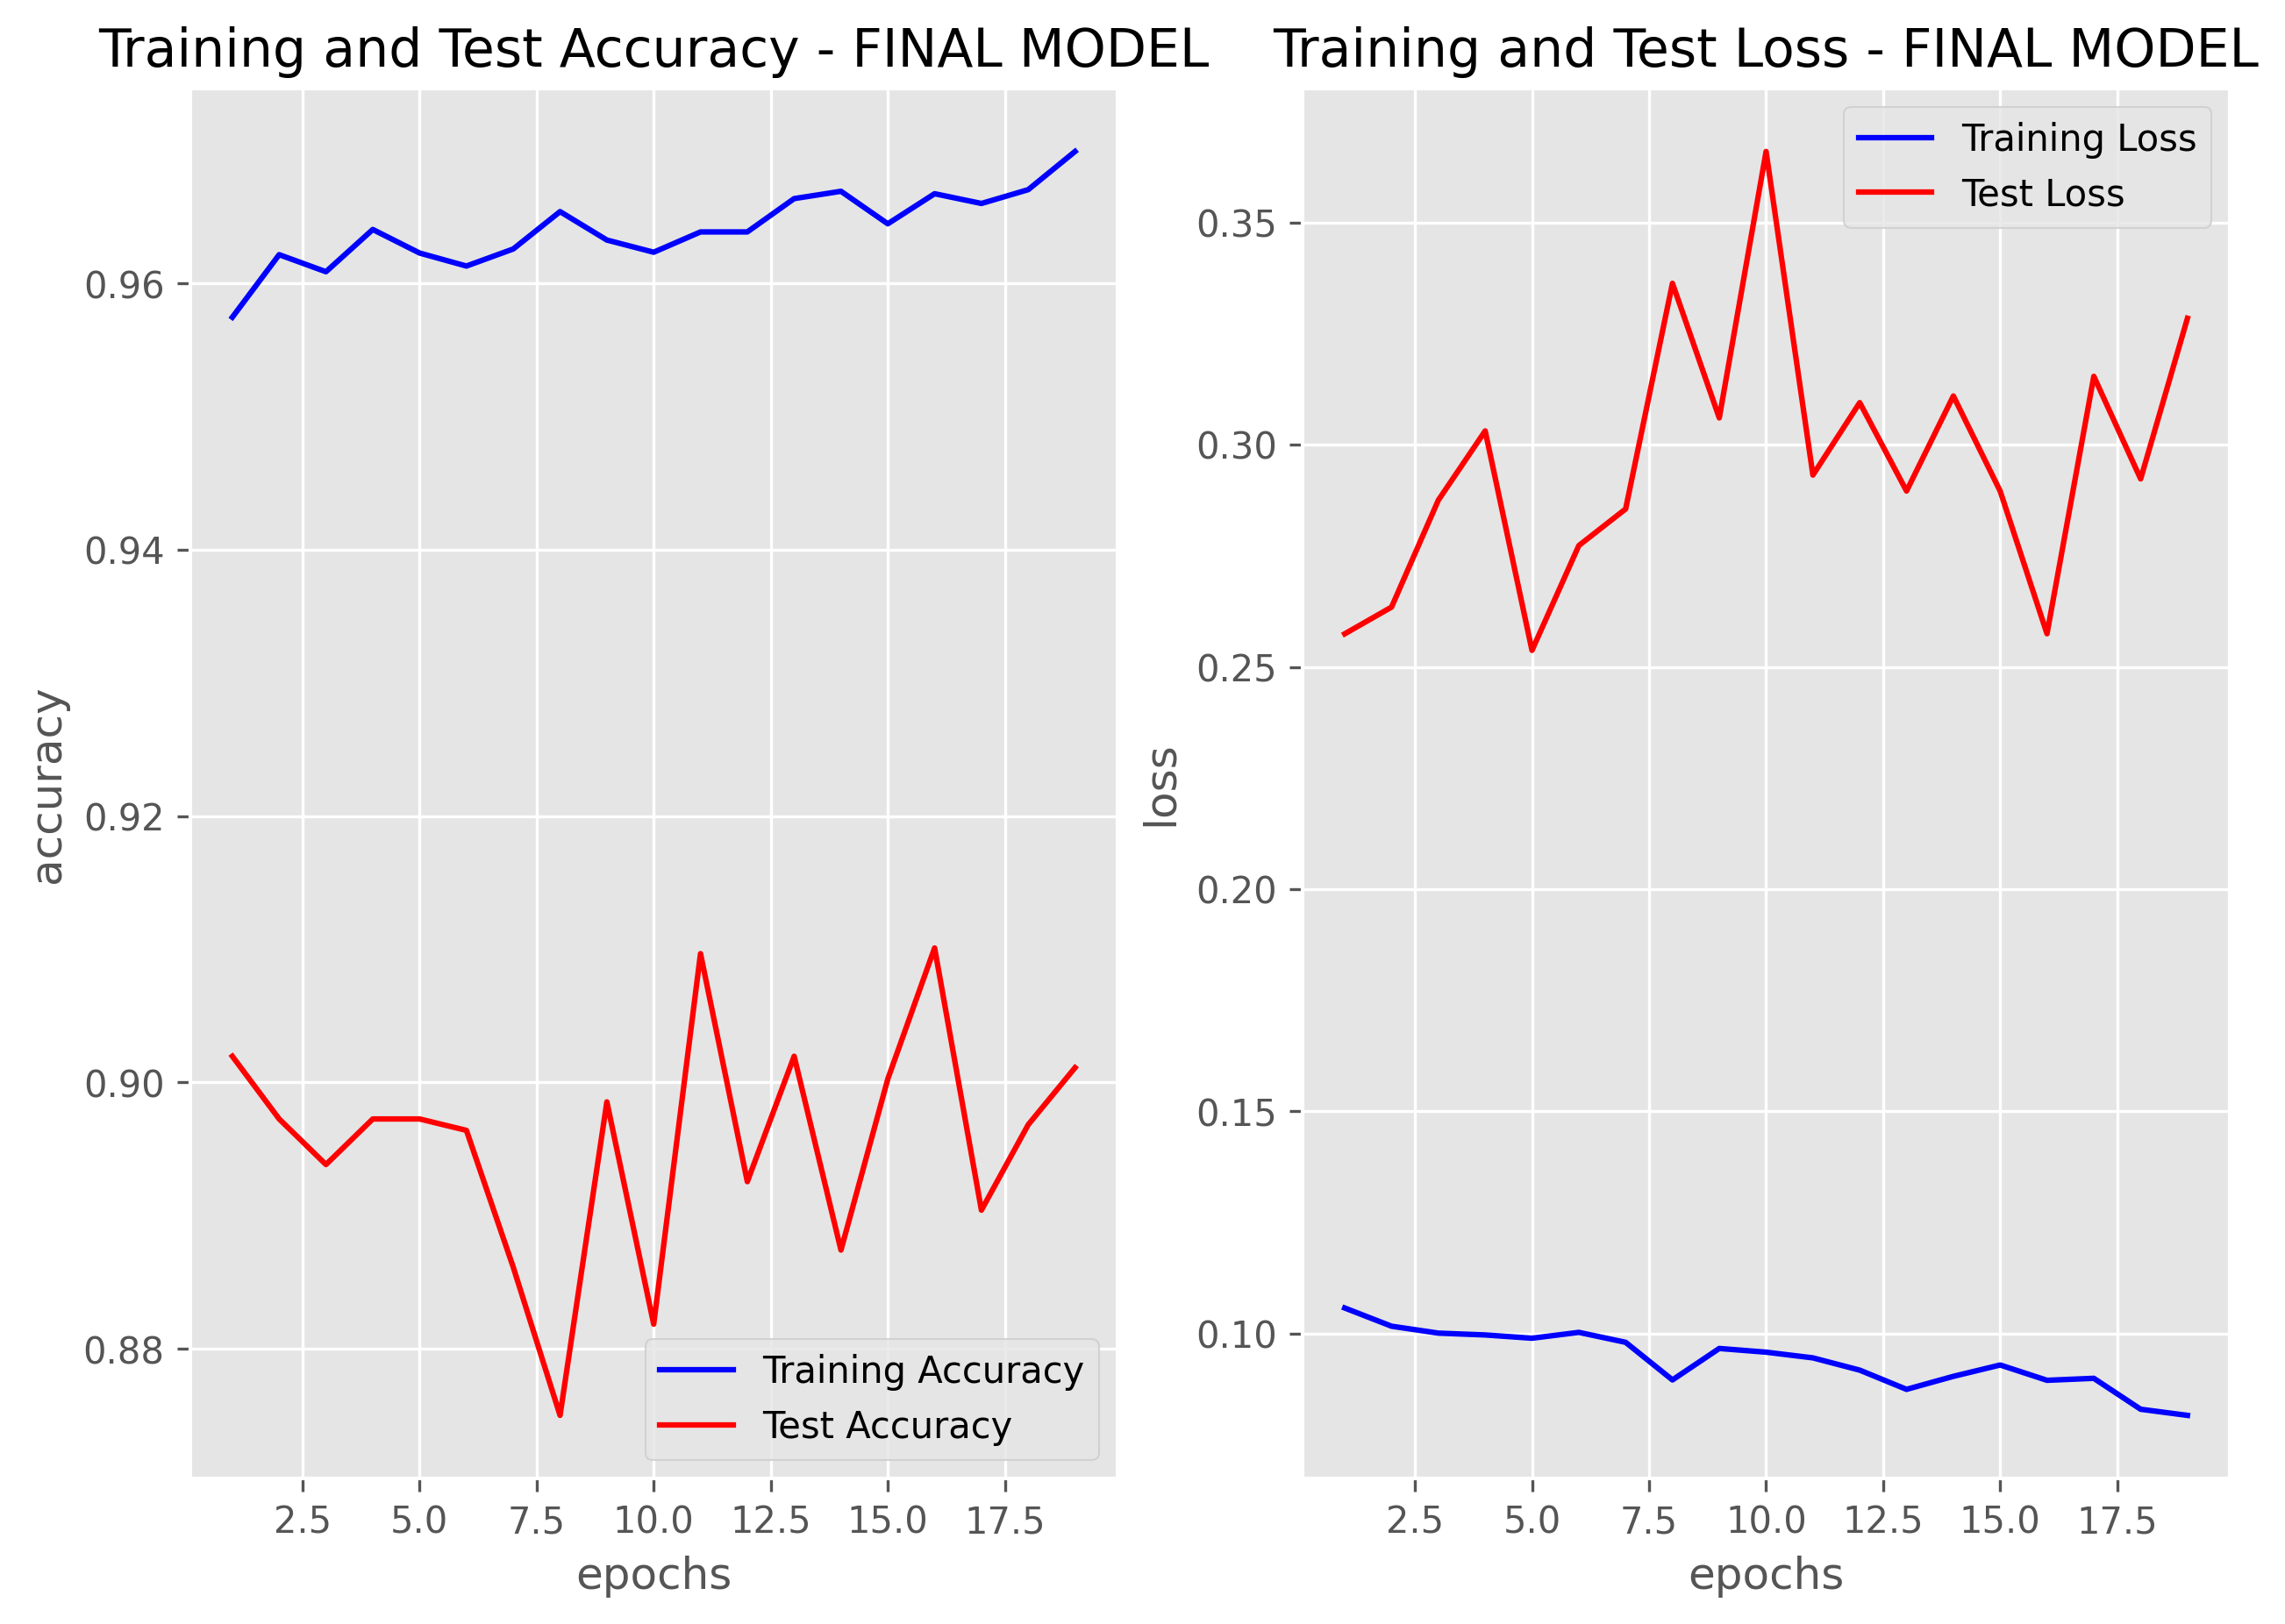

In [47]:
#Plotting Training and Validation Accuracy |+| Training and Validation Loss
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(10,7),dpi= 300)

with plt.style.context('ggplot'):
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, 'b', label='Training Accuracy')
  plt.plot(epochs_range, val_acc, 'r',label='Test Accuracy')
  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.title('Training and Test Accuracy - FINAL MODEL')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, 'b', label='Training Loss')
  plt.plot(epochs_range, val_loss, 'r', label='Test Loss')
  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.title('Training and Test Loss - FINAL MODEL')

In [48]:
train_loss, train_acc = hypermodel.evaluate(train_df_color)
print("Train Loss: "+str(train_loss))
print("Train Accuracy: "+str(train_acc))
validation_loss, validation_acc = hypermodel.evaluate(validation_df_color)
print("Validation Loss: "+str(validation_loss))
print("Validation Accuracy: "+str(validation_acc))
test_loss, test_acc = hypermodel.evaluate(test_df_color)
print("Test Loss: "+str(test_loss))
print("Test Accuracy: "+str(test_acc))


513/513 [==============================] - 2s 4ms/step - loss: 0.1466 - binary_accuracy: 0.9440
Train Loss: 0.1465606689453125
Train Accuracy: 0.9440410137176514
147/147 [==============================] - 1s 4ms/step - loss: 0.2166 - binary_accuracy: 0.9179
Validation Loss: 0.21659483015537262
Validation Accuracy: 0.9178578853607178
73/73 [==============================] - 1s 9ms/step - loss: 0.3254 - binary_accuracy: 0.9003
Test Loss: 0.3254166841506958
Test Accuracy: 0.900256872177124


####ADDITIONAL SECTION FOR HYPERPARAMETERS TUNING FOR THE GRAYSCALE DATA

In [68]:
def build_model(hp):

  activation = hp.Choice("activation", ['relu'])
  dropout = hp.Float("dropout", min_value = 0.1, max_value = 0.3, step = 0.1)
  lr = hp.Float("lr", min_value=0.0004, max_value=0.001, step = 0.0002)
  units = hp.Int("units", min_value=32, max_value=512, step=32)

  model = tf.keras.Sequential([
      augmentation,
      #no rescaling for gray data since it is already rescaled
      
      tf.keras.layers.Conv2D(32, (3,3), input_shape=X_train.shape[1:],strides = 1, activation = 'relu' ),
      tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
      
      tf.keras.layers.Conv2D(64, (3,3), strides = 1, activation = 'relu'),
      tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
      
      tf.keras.layers.Conv2D(128, (3,3), strides = 1, activation = 'relu'),
      tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
      
      tf.keras.layers.Conv2D(256, (3,3), strides = 1, activation = 'relu'),
      tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
      
      tf.keras.layers.Flatten(),
      
      tf.keras.layers.Dense(units=units, activation=activation),
      tf.keras.layers.Dropout(dropout),
      
      tf.keras.layers.Dense(units=units, activation=activation),
      tf.keras.layers.Dropout(dropout),
      
      tf.keras.layers.Dense(units=units, activation=activation),
      tf.keras.layers.Dropout(dropout),
      
      tf.keras.layers.Dense(1, activation='sigmoid'),  
      ], name = 'vgg4_color_cv')
  
  model.compile(
        loss= "binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=["binary_accuracy"]
    )
  
  return model

build_model(keras_tuner.HyperParameters())

In [69]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_binary_accuracy",
    max_trials=15,
    executions_per_trial=1,
    overwrite=True,
    directory="keras_tuner_results",
    project_name="cats_and_dogs_image_classification",
)

In [70]:
tuner.search_space_summary()
     

Search space summary
Default search space size: 4
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu'], 'ordered': False}
dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
lr (Float)
{'default': 0.0004, 'conditions': [], 'min_value': 0.0004, 'max_value': 0.001, 'step': 0.0002, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}


In [71]:
stop_early = [ tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)]

In [72]:
tuner.search(X_train,y_train,
             batch_size=64, 
             epochs=15, 
             validation_data = (X_validate, y_validate),
             callbacks = stop_early)

Trial 15 Complete [00h 02m 34s]
val_binary_accuracy: 0.8571123480796814

Best val_binary_accuracy So Far: 0.8720632195472717
Total elapsed time: 00h 36m 29s


In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=15)[0]

In [ ]:
best_hyperparameters.values
    

{'activation': 'relu', 'dropout': 0.2, 'lr': 0.0004, 'units': 96}

In [ ]:
hypermodel = tuner.hypermodel.build(best_hyperparameters)

# Train the model on the training set for 20 epochs
stop_early = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)]
history = hypermodel.fit(X_train,y_train, epochs=20, validation_data = (X_validate, y_validate), callbacks = stop_early)

#epoch with the highest validation accuracy
val_acc_per_epoch = history.history['val_binary_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/20
513/513 [==============================] - 19s 34ms/step - loss: 0.6832 - binary_accuracy: 0.5647 - val_loss: 0.6624 - val_binary_accuracy: 0.6202
Epoch 2/20
513/513 [==============================] - 17s 32ms/step - loss: 0.6565 - binary_accuracy: 0.6182 - val_loss: 0.6084 - val_binary_accuracy: 0.6736
Epoch 3/20
513/513 [==============================] - 17s 32ms/step - loss: 0.6121 - binary_accuracy: 0.6686 - val_loss: 0.5305 - val_binary_accuracy: 0.7354
Epoch 4/20
513/513 [==============================] - 16s 32ms/step - loss: 0.5629 - binary_accuracy: 0.7143 - val_loss: 0.5428 - val_binary_accuracy: 0.7332
Epoch 5/20
513/513 [==============================] - 17s 33ms/step - loss: 0.5277 - binary_accuracy: 0.7410 - val_loss: 0.4925 - val_binary_accuracy: 0.7631
Epoch 6/20
513/513 [==============================] - 17s 32ms/step - loss: 0.4949 - binary_accuracy: 0.7593 - val_loss: 0.4707 - val_binary_accuracy: 0.7691
Epoch 7/20
513/513 [==============================] 

In [ ]:
hypermodel = tuner.hypermodel.build(best_hyperparameters)

In [ ]:
import statistics
#zero-one loss
zero_one_loss = [1 - i for i in accuracy]
zero_one_loss
#accuracy
mean=statistics.mean(accuracy)
st_dv=statistics.stdev(accuracy)
#binary loss
mean_l=statistics.mean(loss)
st_dv_l=statistics.stdev(loss)
#zero-one loss
mean_01=statistics.mean(zero_one_loss)
st_dv_01=statistics.stdev(zero_one_loss)
print(f"Average loss: {mean_l} with st. deviation:{st_dv_l}")
print(f"Average zero-one loss: {mean_01} with st. deviation:{st_dv_01}")
print(f"Average accuracy: {mean} with st. deviation:{st_dv}")


Average loss: 0.23272240161895752 with st. deviation:0.06023180908200354
Average zero-one loss: 0.09827876091003418 with st. deviation:0.03332474165246877
Average accuracy: 0.9017212390899658 with st. deviation:0.03332474165246877


In [ ]:
#========================That is the end of the project==============================